# Albums Sales Analysis using SQL

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
db='chinook.db'

def run_query(q):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(q,conn)

def run_command(c):
    with sqlite3.connect("chinook.db") as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q='''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Sales of Genre
### Finding out which genre sells the best in the USA market

In [3]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    WHERE c.country = "USA"
    )
SELECT g.name genre,
       COUNT(uts.invoice_line_id) tracks_sold,
       cast(COUNT(uts.invoice_line_id) AS Float)/(
            SELECT COUNT(*) FROM usa_tracks_sold
        ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
   '''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


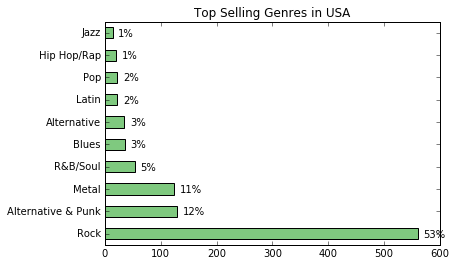

In [4]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index('genre', drop=True, inplace=True)

genre_sales_usa['tracks_sold'].plot.barh(
    title = "Top Selling Genres in USA",
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label,'tracks_sold']
    label = (genre_sales_usa.loc[label,'percentage_sold']*100
            ).astype(int).astype(str)+"%"
    plt.annotate(str(label),(score+10,i-0.15))
    
plt.show()

#### Based on the sales of tracks in each genre, I suggest to add three new albums from the following artists: Red Tone (Punk), Meteor and the Girls(Pop) and Slim Jim Bites(Blues).#### Punk, Pop and Blues only make up 17% of the sales. I also suggest to lookout for artists and album in Rock genre, which takes 53%.

## Analyzing Agent Sales Performance

In [5]:
#query to find total$ of sales assigned to TOP-3 sales support agent
agent_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name agent,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;
'''

run_query(agent_sales_performance)

,agent,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


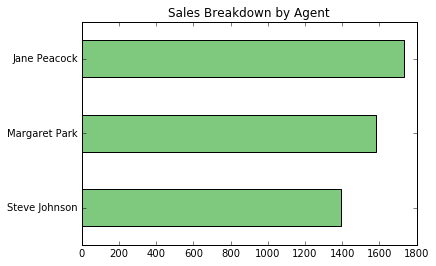

In [6]:
agent_sales = run_query(agent_sales_performance)

agent_sales.set_index("agent", drop=True, inplace=True)
agent_sales.sort_values("total_sales", inplace=True)
agent_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Agent',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

### The agent's performance roughly corresponds with their hiring dates.

## Analyzing Sales by Country

In [7]:
#for country only has one customer, marks as 'Other'
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN(   
               SELECT COUNT(*)
               FROM customer 
               WHERE country=c.country           
               )=1 THEN "Other"
           ELSE c.country
        END As country,
        c.customer_id,
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    )
SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
   (
    SELECT 
        country, 
        COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price)/COUNT(DISTINCT customer_id) customer_lifetime_value,
        SUM(unit_price)/COUNT(DISTINCT invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END As sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


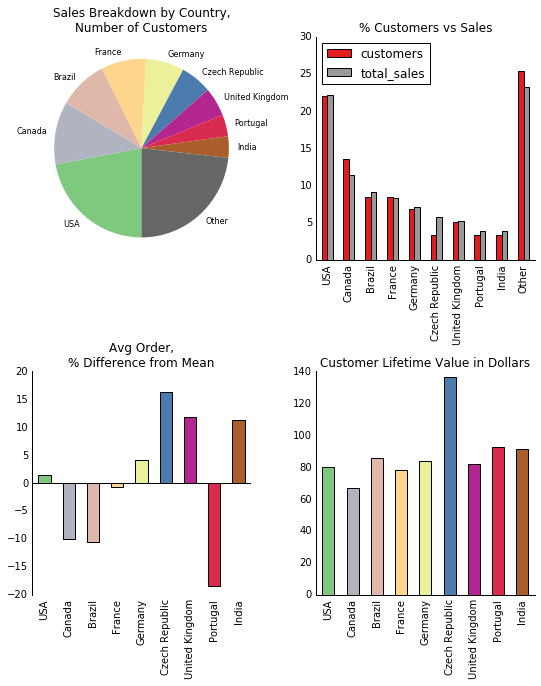

In [8]:
import numpy as np
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    )
# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="% Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Avg Order,\n% Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value in Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

### Based on the data, we could pay more attention on Czech Repulic, UK and India for future opportunity.
But as the sample size is not large enough to support a high confidence, I would recommend to run small campaigns in these countries to collect more data.

## Whole Album vs. Indivdual Track for MAX Revenue

What if the store purchases only the most popular tracks from each album from record companies, instead of purchasing every track from an album?

In [9]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Only 18.6% of customers bought whole ablums. So I suugest to promote new strategy by buying only polupar tracks instead of the whole ablums from record companies.